In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [3]:
path = "/home/voldemort/Downloads/Fashion_MNIST"

In [4]:
import os
train_img = os.path.join(path, 'train-images-idx3-ubyte')
train_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
        
test_img = os.path.join(path, 't10k-images-idx3-ubyte')
test_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

In [5]:
convert(train_img, train_lbl,
        "fashion_mnist_train.csv", 60000)
convert(test_img, test_lbl,
        "fashion_mnist_test.csv", 10000)

In [6]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);

In [8]:
train_dataset = FashionMNISTDataset(csv_file="fashion_mnist_train.csv");
test_dataset = FashionMNISTDataset(csv_file="fashion_mnist_test.csv");

In [9]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False);

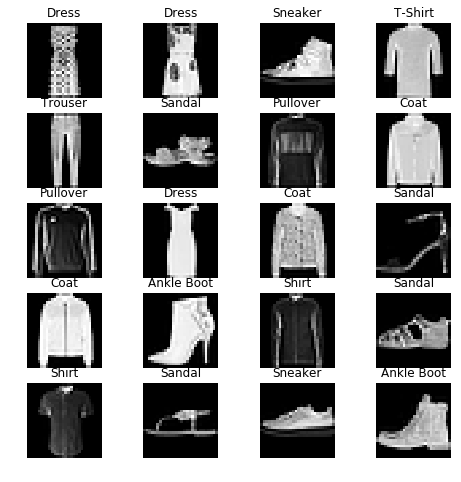

In [11]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [13]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.5919
Epoch [1/5], Step [200/600], Loss: 0.4231
Epoch [1/5], Step [300/600], Loss: 0.4558
Epoch [1/5], Step [400/600], Loss: 0.4892
Epoch [1/5], Step [500/600], Loss: 0.2657
Epoch [1/5], Step [600/600], Loss: 0.3921
Epoch [2/5], Step [100/600], Loss: 0.3128
Epoch [2/5], Step [200/600], Loss: 0.2302
Epoch [2/5], Step [300/600], Loss: 0.1702
Epoch [2/5], Step [400/600], Loss: 0.2799
Epoch [2/5], Step [500/600], Loss: 0.3998
Epoch [2/5], Step [600/600], Loss: 0.3152
Epoch [3/5], Step [100/600], Loss: 0.2961
Epoch [3/5], Step [200/600], Loss: 0.1902
Epoch [3/5], Step [300/600], Loss: 0.2274
Epoch [3/5], Step [400/600], Loss: 0.1147
Epoch [3/5], Step [500/600], Loss: 0.4605
Epoch [3/5], Step [600/600], Loss: 0.3035
Epoch [4/5], Step [100/600], Loss: 0.2135
Epoch [4/5], Step [200/600], Loss: 0.2720
Epoch [4/5], Step [300/600], Loss: 0.3552
Epoch [4/5], Step [400/600], Loss: 0.2823
Epoch [4/5], Step [500/600], Loss: 0.2966
Epoch [4/5], Step [600/600], Loss:

In [17]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.float())
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [18]:
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.1990199019902 %
